In [2]:
import numpy as np
import matplotlib.pyplot as plt
from configs.config import Config
import yaml

Using CUDA


In [3]:
config_path = 'configs/config.yaml'
with open(config_path, "r") as f:
    config_dict = yaml.load(f, Loader=yaml.FullLoader)
    config = Config(config_dict)

Seed given in config, setting deterministic run


First, we plot and save losses for each p value

In [27]:
def plot_loss():
    num_tasks = 5
    plt.rcParams['font.size'] = 20
    fig, ax = plt.subplots(5, 1, figsize = (20, 30))
    for i, p in enumerate([0.001, 0.01, 0.1, 0.5, 1]):
        for k in range(num_tasks):
            loss_path = f'{config.model_save_dir}/{p}/train/task_{k}/loss.npy'
            loss_arr = np.load(loss_path)
            ax[i].plot(loss_arr, label = f'task {k}')
        ax[i].set_title(f'Training Loss for p = {p}')
        ax[i].set_ylabel('Cross Entropy Loss')
        ax[i].legend()
    ax[-1].set_xlabel('epoch')
    plt.tight_layout()
    plt.savefig('callback_plots/train_loss.png')
    plt.show()


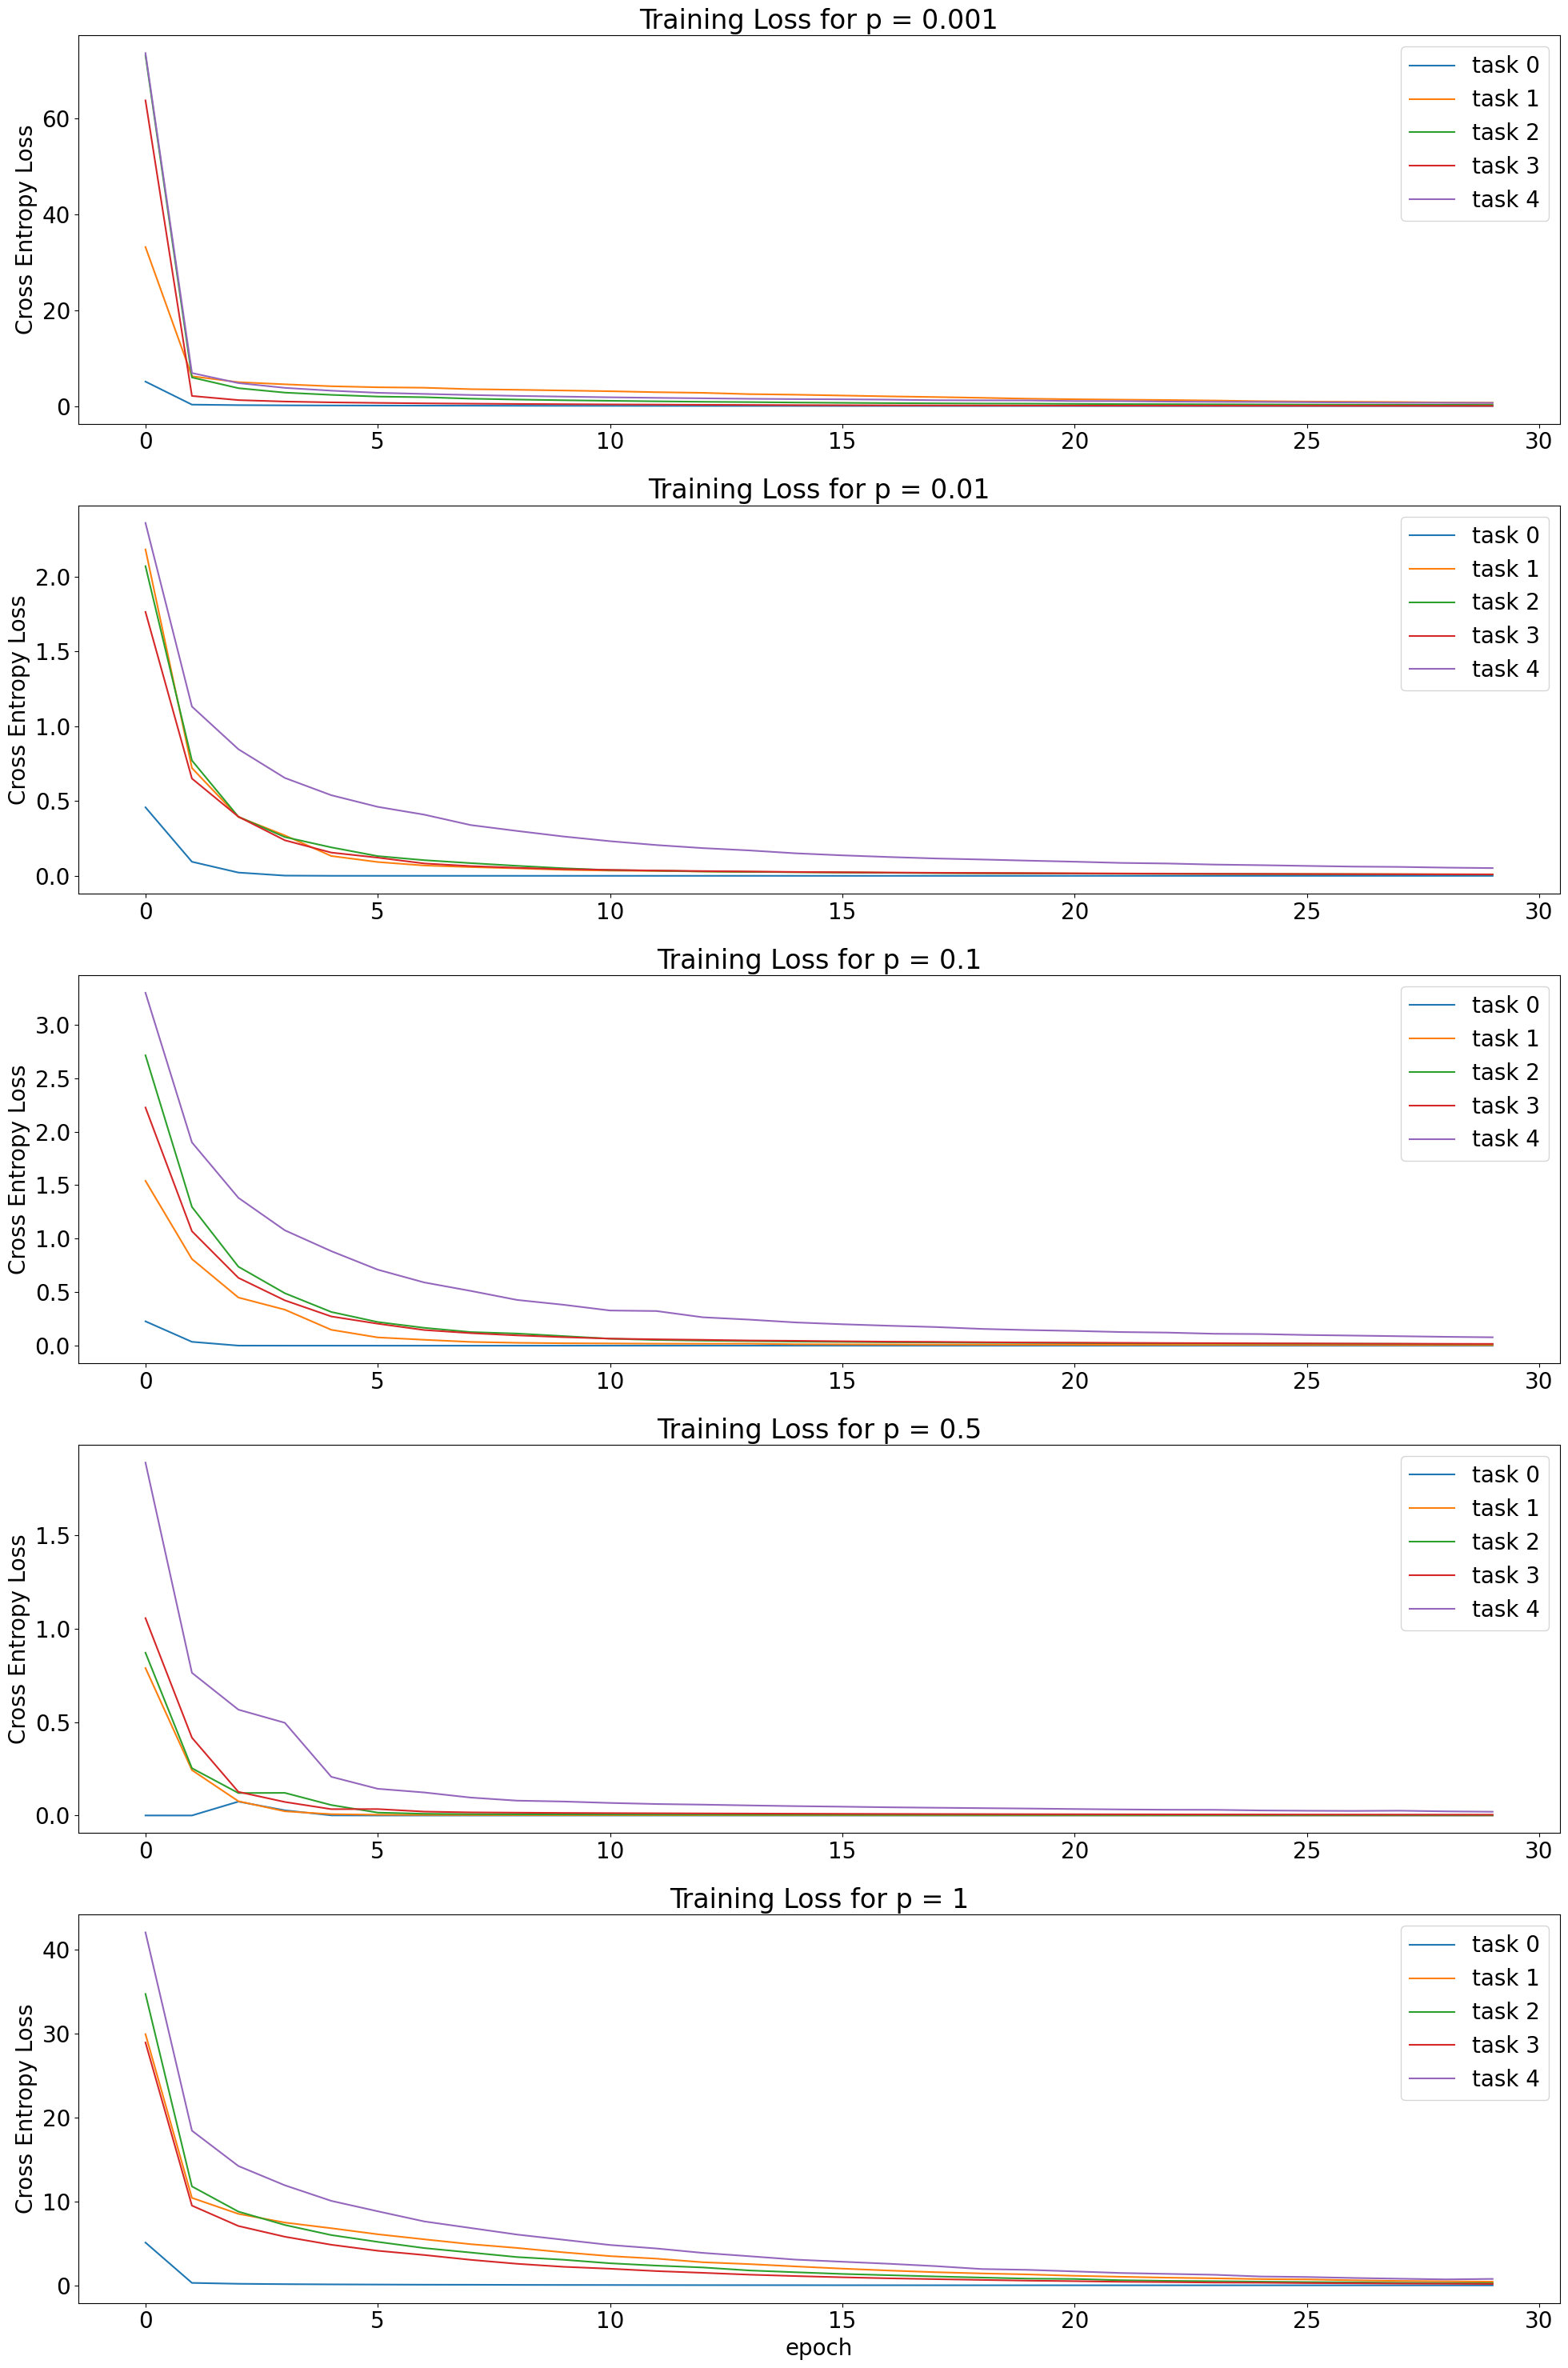

In [28]:
plot_loss()

Now, we plot the training accuracy

In [37]:
def plot_accuracy():
    plt.rcParams['font.size'] = 20
    plt.figure(figsize = (20, 10))
    for i, p in enumerate([0.001, 0.01, 0.1, 0.5, 1]):
        acc_path = f'{config.model_save_dir}/{p}/train/acc.npy'
        acc_arr = np.load(acc_path)
        plt.plot(acc_arr, label = f'p = {p}')
    plt.title(f'Accuracy for seleceted p training')
    plt.ylabel('accuracy')
    plt.xlabel('task number')
    plt.xticks(np.arange(0, 5, 1))
    plt.legend()
    plt.tight_layout()
    plt.savefig('callback_plots/accuracy.png')
    plt.show()

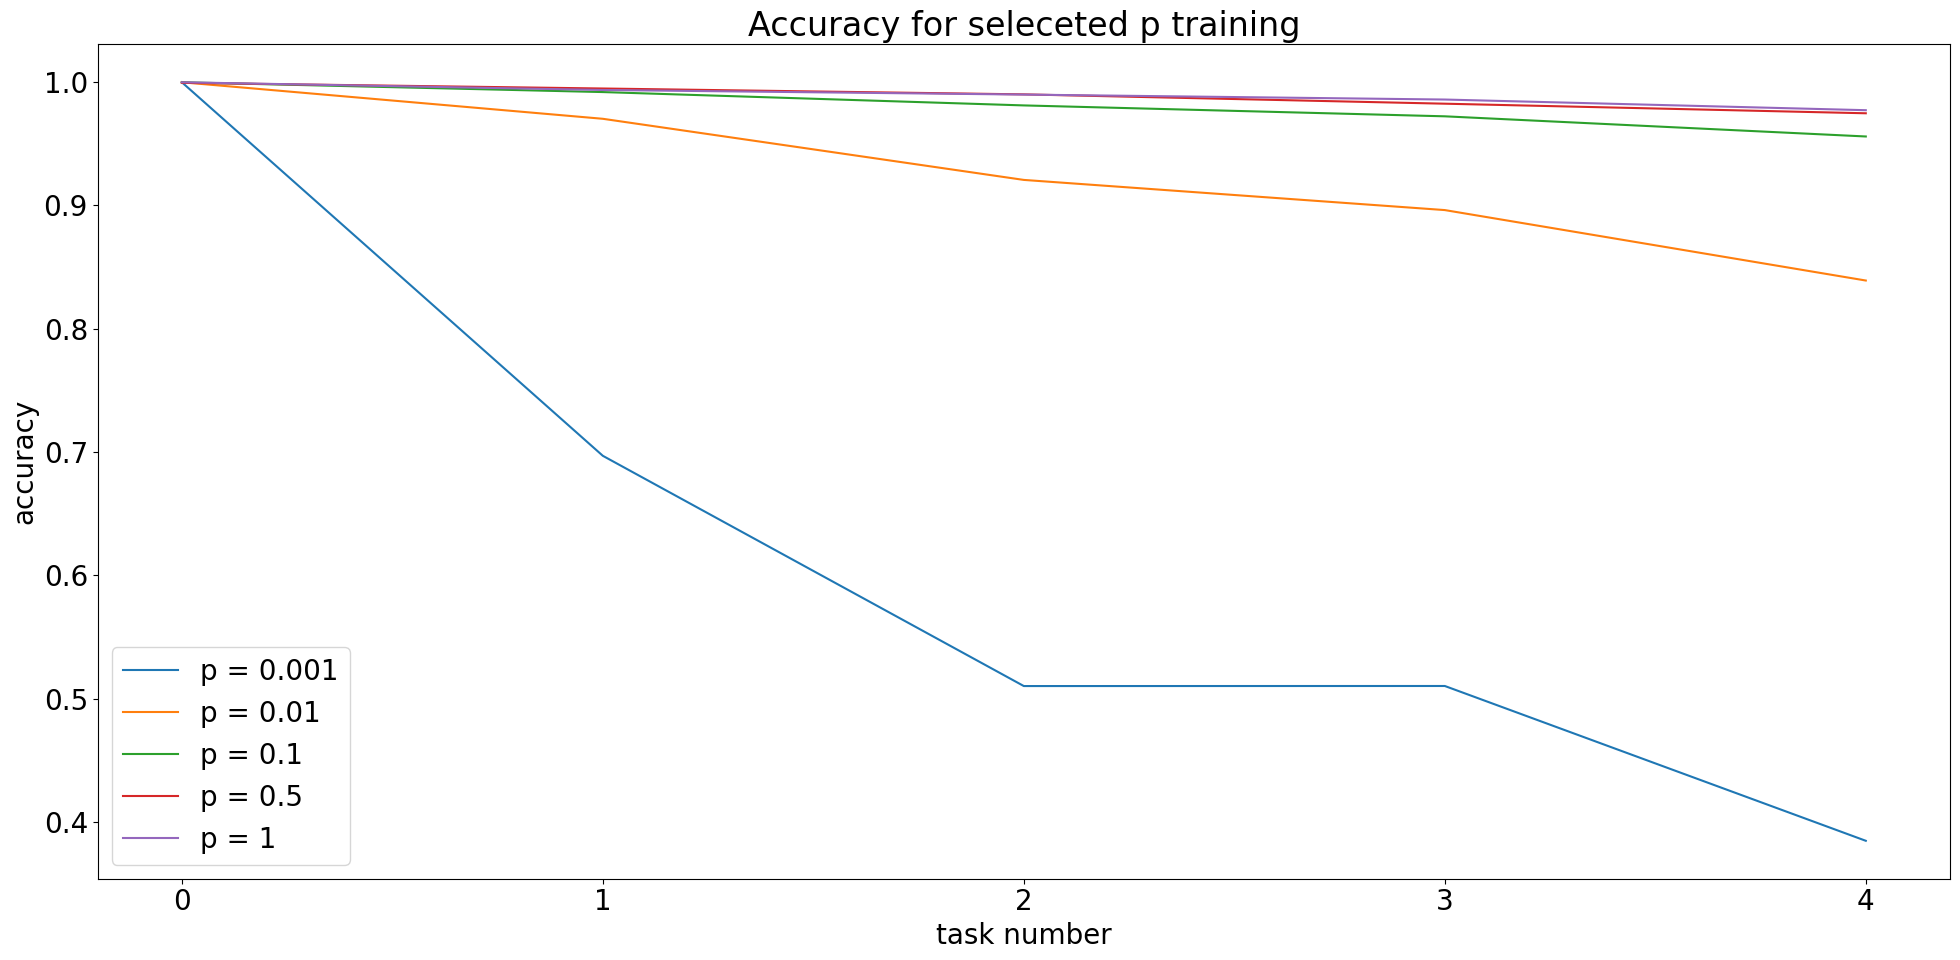

In [38]:
plot_accuracy()

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from similarity_utils import vec_to_img, get_rmse, get_uiq
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr

In [27]:
def cos_sim(w1, w2):
    if np.linalg.norm(w1)*np.linalg.norm(w2) == 0:
        return 1
    return np.dot(w1, w2)/(np.linalg.norm(w1)*np.linalg.norm(w2))

In [28]:
def compute_ssim(img1, img2):
    (score, _) = ssim(img1, img2, full = True)

    return score

In [33]:
def get_p_acc(plot = False):
    p_vals = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9])
    p_acc = np.zeros_like(p_vals)
    
    for i, p in enumerate(p_vals):
        acc_dir = f'models/mnist_split/{p}/train/acc.npy'
        acc_arr = np.load(acc_dir)
        p_acc[i] = np.mean(acc_arr)
    
    if plot:
        plt.plot(p_acc)
        plt.show()

    return p_acc
    

In [30]:
get_p_acc(plot = False)

array([0.6204405 , 0.86322195, 0.92494794, 0.968829  , 0.97988167,
       0.98506906, 0.98689843, 0.98727833, 0.98796084, 0.98748587,
       0.98784347, 0.98821899, 0.98800543])

In [34]:
def compare_gradients(approx, ideal, metric_func):
    num_weights, num_pix = approx.shape

    distances = np.zeros(num_weights)

    for i in range(num_weights):

        approx_weight = approx[i] #vec_to_img(approx[i])
        ideal_weight = ideal[i] #vec_to_img(ideal[i])

        distances[i] = metric_func(approx_weight, ideal_weight)

    return np.mean(distances)


def get_grad_dist(metric_func):
    p_vals = np.array([0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.9])
    p_grad_dist = np.zeros_like(p_vals)
    run_num = 0
    num_tasks = 5
    grad_name = 'grad_layers.0.weight'

    for i, p in enumerate(p_vals):
        print(p)
        task_vals = np.zeros(5)
        for task in range(num_tasks):
            p_grad_dir = f'models/mnist_split/{p}/run_{run_num}/ideal_grad_task_{task}/{grad_name}.npy'
            p_grad_arr = np.load(p_grad_dir)

            ideal_grad_dir = f'models/mnist_split/1/train/task_{task}/{grad_name}.npy'
            ideal_grad_arr = np.load(ideal_grad_dir)

            task_vals[task] = compare_gradients(p_grad_arr, ideal_grad_arr, metric_func)

        p_grad_dist[i] = np.mean(task_vals)
    return p_grad_dist


In [14]:
def plot_acc_vs_dist(metric):
    acc = get_p_acc(plot = False)
    dist = get_grad_dist(metric)
    print(dist)

    plt.plot(acc, dist)
    plt.show()

0.001
0.005
0.01
0.05
0.1
0.5
0.9
[-0.01680264  0.05031205  0.02385365  0.12855838  0.12785738  0.15843815
  0.09612297]


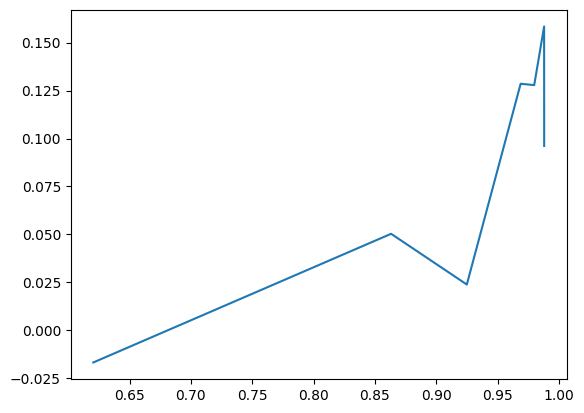

In [35]:
plot_acc_vs_dist(cos_sim)

0.001


c:\Users\alanh\anaconda3\envs\continualLearning\lib\site-packages\image_similarity_measures\quality_metrics.py:276: RuntimeWarning: invalid value encountered in divide
  q = np.nan_to_num(numerator / denominator)


0.005
0.01
0.05
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


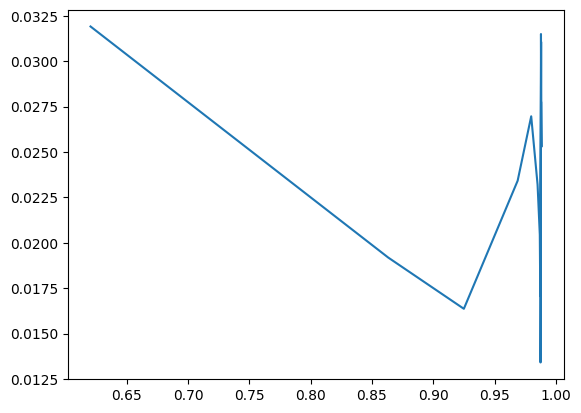

In [32]:
plot_acc_vs_dist(get_uiq)